<div class="alert alert-block alert-warning">

# <p style="text-align: center;">Lab 3 (Weeks 6,7): Multi-Layer Perceptrons (MLP) </p>

<img src="https://viso.ai/wp-content/uploads/2021/04/multilayer-perceptrons-MLP-concept-1.jpg" width="400" height="200" />

<!-- ![linear-vs-logistic-regression--medium](https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg) -->

Welcome to your third lab of ECE4179! Labs in this unit will run as a help desk and they are not mandatory to attend.

The two notebooks provided contain all the code and comments that you need to submit. Feel free to add in your own markdown for additional comments. After completion, You need to submit both Jupyter Notebooks (.ipynb file) to Moodle. Make sure you run the Notebooks before submitting and all outputs are visible.

In this Lab, you will find three tasks distributed across two notebooks: COVID and FashionMNIST. These tasks will guide you through to learn using a deep learning framework (Pytorch lightning) for MLP based problems. These knowledge and skills will be essential for lab 4 and assignment, and in general, critical to get you prepared to enter the deep learning world.

- <b>Task 1:</b> Shallow MLP for binary classification of COVID-19 X-ray images
- <b>Task 2:</b> Anaylsing convergence and accuracy
- <b>Task 3:</b> MLP for multiclass classification of the FasionMNIST dataset

Each task will contain code to complete, and worded questions, so ensure you complete both before submitting.

Good luck with the Lab! Submit it before the deadline to enjoy full marks.

__Submission details:__
- __Make sure you have run all your cells from top to bottom (you can click _Kernel_ and _Restart Kernel and Run All Cells_).__ </br>
- __Submit the Jupyter Notebooks (_Lab_3_student_COVID.ipynb_) and (_Lab_3_student_FashionMNIST.ipynb_).__
- __Outputs must be visible upon submission. We will also be re-running your code__

<b>Enter your student details below</b>

- <b>Student Name:</b> Firstname Lastname
- <b>Student ID:</b> 123456789

<div class="alert alert-block alert-danger">

## Table of Contents

* [Task 3: MLP for FashionMNIST dataset](#mlp_for_fasionmnist)
    * [3.1: Define transforms and create a custom dataset](#3_1)
    * [3.2: Design a two hidden layer MLP](#3_2)
    * [3.3: Train & Evaluate: Train and evaluate model's performance](#3_3)
    * [3.4: Visualization: Analysis and Visualization](#3_4)

<div class="alert alert-block alert-warning">

# Before you begin <a class="anchor" id="Libraries"></a>

We have provided some numerical answers for you to aim for. To replicate these results, do not change any of the codes that are labelled "Do not change".

Throughout this lab, there will be code and written answers that you need to fill in / complete. Please read the instructions carefully. The comments in the code snippet and markdown text will guide you on what you need to do.

In [3]:
## Libraries, you do not need to import any additional libraries for this lab

import numpy as np ## Numpy is the fundamental building block of understanding tensor (matrices) within Python
import matplotlib.pyplot as plt ## Matplotlib.pyplot is the graphing library that we will be using throughout the semester
import random ## Useful for sampling
# import sys ## Useful to retrieve some system information

import os ## Useful for running command line within python
import pandas as pd ## Useful for data manipulation
from IPython.display import Image ## For markdown purposes
from IPython.display import clear_output
import PIL

import torch ## Pytorch is the deep learning library that we will be using
import torch.nn as nn ## Neural network module
import torch.nn.functional as F ## Functional module
from torch import optim ## Optimizer module
from torch.utils.data import DataLoader, random_split ## Under torchvision datasets you can find popular datasets that are frequently used for machine learning/deep learning tasks (eg., MNIST, SVHN, CIFAR10, CIFAR100 etc).
from torch.utils.data.dataset import Dataset ## You can create your own custom dataset using torchvision dataset in-built functionalities.
import torchmetrics ## Torchmetrics is a library that contains metrics for evaluating models
import torchvision ## Torchvision is a library that contains popular datasets, model architectures, and image transformations for computer vision tasks
from torchvision import transforms
from torchmetrics import ConfusionMatrix

import pytorch_lightning as pl ## Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar

from pytorch_lightning import seed_everything

## Setting seeds for reproducibility. Do NOT change these!
seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

Global seed set to 4179


<div class="alert alert-block alert-info">

# Task 3 - MLP for FashionMNIST dataset <a class="anchor" id="mlp_for_fasionmnist"></a>

In this section, we will train a Deep MLPs for classifying 28x28 grayscale images from FashionMNIST dataset that contains images and labels for training, validation and test purposes.


#### In this task, you will work on the following points:
 1. Create a custom Dataset class for the FashionMNIST data. Also create training , validation and testing dataloaders. Visualize some images from the training dataset.

 2. Design a Deep MLP model using PyTorch Lightning Module.

 3. Train and evaluate the MLP model. Report test accuracies.

 4. Visualize experimental results and predictions. Discuss about the performance of the MLP on this dataset with a confusion matrix.

<div class="alert alert-block alert-info">

## Learning Objective

This task is designed to foster an understanding of the process involved in crafting and deploying a basic Multi-Layer Perceptron (MLP) model for training neural networks on the FashionMNIST dataset. By completing this task, you will acquire the following proficiencies:

1. Proficiency in loading the FashionMNIST dataset through PyTorch Lightning, ensuring that the data is suitably prepared for model training.

2. Competence in constructing an MLP model tailored for the classification of FashionMNIST data. This will be achieved by leveraging the PyTorch Lightning framework.

3. Application of the stochastic gradient descent (SGD) optimization technique to facilitate the training of the MLP model on the FashionMNIST dataset.

4. Capability to visualize and evaluate the performance of the MLP model on the provided samples. This will provide insights into how effectively the model aligns with the underlying data distribution.

<div class="alert alert-block alert-info">

## 3.1 Define transforms and create a custom dataset <a class="anchor" id="3_1"></a>

In this task, we will define transforms and use a different way to create dataset.

In [4]:
# ================================================
# Do not change these settings!
# ================================================

data_mean = [0.5]
data_std = [0.5]

# data transform 
data_transform = transforms.Compose([
    # Converting the processed images back to Tensor: https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
    transforms.ToTensor(),
    transforms.Normalize(data_mean, data_std) # Normalizing the data
])

# ================================================
# Do not change these settings!
# ================================================

**(a) Create a custom dataset**

A custom Dataset class takes **Dataset** ([torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) as the parent class. There are three basic methods that we must modify for a custom Dataset: \_\_init__ , \_\_len__ and \_\_getitem__.

 - \_\_init__ function is generally used to load the raw data and create samples and labels.

 - \_\_len__ function returns the number of samples in the dataset.

 - \_\_getitem__ function takes an index and return a certain sample-label pair.

In [15]:
class FashionMNISTData(Dataset):
    def __init__(self, trn_val_tst, transform=None):
        # Load numpy data, the defualt location should be './data/fashionmnist.npz'
        data = np.load('./data/fashionmnist.npz')
        self.transform = transform

        # Components can be accessed like a dictionary after the file has been loaded, and the file contains the following:
        # 'arr_0' : samples (images) for the training data
        # 'arr_1' : labels for the training data
        # 'arr_2' : samples (images) for the validation data
        # 'arr_3' : labels for the validation data
        # 'arr_4' : samples (images) for the test data
        # 'arr_5' : labels for the test data

        # We use trn_val_tst to specify the train, validation or test dataset. (0 for train, 1 for validation and 2 for test)
        if trn_val_tst == 0:
            # Create samples and labels for training data
            self.images = data["arr_0"].T
            self.labels = data["arr_1"]
        elif trn_val_tst == 1:
            # Create samples and labels for validation data
            self.images = data["arr_2"].T
            self.labels = data["arr_3"]
        else:
            # Create samples and labels for test data
            self.images = data["arr_4"].T
            self.labels = data["arr_5"]
        
    # Define len function
    def __len__(self):
        return len(self.labels)

    # Define getitem function
    def __getitem__(self, idx):
        # Check if idx is a tensor. If its a tensor, convert idx to a list
        if torch.is_tensor(idx):
            idx.to_list()
        # Get the sample-label pair of the index (resizing the images to 28 x 28)
        sample = self.images[idx, :].reshape((28,28))
        label = self.labels[idx]

        # Apply transform
        # Here you do not need to consider torch.no_grad() as the samples are not being passed into any networks.
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, label

**(b) Using the Dataset to create train/val/test Dataloader**

With the custom Dataset class we just defined, let's create the dataloader objects for the training, validation and test data. 

In [16]:
BATCH_SIZE = 100 # Specify a batch size of 100

# Create a training Dataset using the Dataset class you just defined in (a) 
trainset = FashionMNISTData(0, data_transform)
# Create a training DataLoader with the training Dataset, setting batch_size, and enabling shuffling.
trainloader = DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False) 

# Repeat the same process for the validation data to create the valloader with the same batch_size and disable shuffling.
valset = FashionMNISTData(1, data_transform)
valloader = DataLoader(valset, shuffle=False, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False) 

# Repeat the same process for the test data to create the testloader with the same batch_size and disable shuffling.
testset = FashionMNISTData(2, data_transform)
testloader = DataLoader(testset, shuffle=False, batch_size=BATCH_SIZE, num_workers=0, pin_memory=False) 

**(c) Check the length of train/val/test datset, image size, and number of potential labels**

Let's **iterate** through the dataloaders you just created to check the dimensions of their elements and figure out how many class labels are there. Remember that images in the FashionMNIST data are of size 28 x 28 (grayscale images). And there should be 10 classes in total.

In [19]:
dataloaders = {"trainloader": trainloader, "valloader": valloader, "testloader": testloader}


#  Iterate through dataloaders and print the requested information
for key in dataloaders.keys():
    iterable = iter(dataloaders[key])
    sample, target = next(iterable)
    print(f"{key} sample data shape: {sample.shape}")
    print(f"{key} target data shape: {target.shape}")
    print(f"{key} target range: {range(torch.min(target), torch.max(target))}")

trainloader sample data shape: torch.Size([100, 1, 28, 28])
trainloader target data shape: torch.Size([100])
trainloader target range: range(0, 9)
valloader sample data shape: torch.Size([100, 1, 28, 28])
valloader target data shape: torch.Size([100])
valloader target range: range(0, 9)
testloader sample data shape: torch.Size([100, 1, 28, 28])
testloader target data shape: torch.Size([100])
testloader target range: range(0, 9)


Expected Output for Trainloader: 

For each batch in trainloader: 	 samples shape: torch.Size([100, 1, 28, 28]) 	 labels shape: torch.Size([100]) 	 labels range: (0, 9)

**(d) Visualise that mini-batches that the training dataloader gives us**

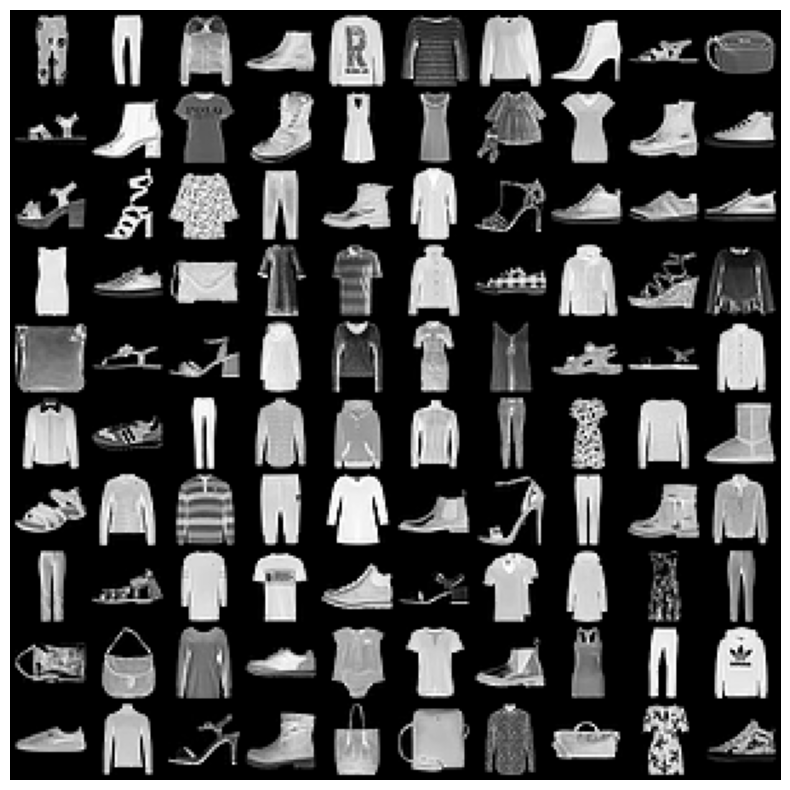

In [21]:
# FashionMNIST images are 28 x 28
img_resolution = 28

# We can create an iterater using the dataloaders and take a random sample
images, labels = next(iter(dataloaders["trainloader"]))

# Reshape the images batch to 100 x 1 x 28 x 28
#images = ???

# Re-normalise pixel values to between 0 and 1 (for imshow purpose)
#images = transforms.Normalise()

# visualize dataset using torchvision grid
plt.figure(figsize = (20,10))
plt.axis('off')
out = torchvision.utils.make_grid(images, nrow=10, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

<div class="alert alert-block alert-info">

## 3.2 Model: Design a two hidden layer MLP <a class="anchor" id="3_2"></a>

Define a MLP with two hidden layer with the following structure:

fc1 : Linear(784 $\times$ n1) $\rightarrow$ ReLU $\rightarrow$ fc2 : Linear(n1 $\times$ n2) $\rightarrow$ ReLU $\rightarrow$ fc3 : Linear(n2 $\times$ 10)

We're going to use the Cross Entropy Loss and SGD similar to task 1 and 2. Train the MLP with a learning rate of 1e-2 and max. epochs. This time, we will use two layers for MLP and not have a pre-trained CNN. This is because the image sizes are much smaller, so the amount of parameters required to only use MLP is relatively smaller compared to the dataset from tasks 1 & 2. 

In [26]:
class TwoHL_MLP(pl.LightningModule): ## HL refers to hidden layer, so two hidden layers in this case which is why it is considered "deep"!
    def __init__(self, n1, n2, learning_rate=1e-2, traindataloader=None, valdataloader=None, testdataloader=None):
        super().__init__()
        
        # define learning rate
        self.learning_rate = learning_rate

        # define loss function (Cross entropy loss)
        self.loss_fun = nn.CrossEntropyLoss()

        # define neural layers
        self.linear1 = nn.Linear(784, n1)
        self.linear2 = nn.Linear(n1, n2)
        self.linear3 = nn.Linear(n2, 10)

        # define metrics, you can use torchmetrics to define the accuracies. Define it for train, val, and test.
        self.train_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

        # Define dataloaders
        self.traindataloader = traindataloader
        self.valdataloader = valdataloader
        self.testdataloader = testdataloader

    def forward(self, x):

        # flatten the images so it fits into the MLP structure
        x = x.reshape(x.shape[0], -1)
        
        # Pass input through neural layers
        out1 = F.relu(self.linear1(x))
        out2 = F.relu(self.linear2(out1))
        out3 = self.linear3(out2)

        return out3 # Return the output 

    def training_step(self, batch, batch_idx):
        # Compute loss for each batch:
        # Get the two variables of each batch
        x,y = batch
        # Do the prediction
        logits = self(x)
        preds = logits.argmax(1)
        # Calculate the loss
        # Apply the loss function here
        loss = self.loss_fun(logits, y)

        # Compute accuracy and update the train_accuracy
        self.train_accuracy.update(preds, y)
        
        # Record accuracy and loss
        # Calling self.log will surface up scalars for you in TensorBoard
        # You may add more logs as you think necessary
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

        # Return the loss
        return loss

    def validation_step(self, batch, batch_idx):
        # Compute loss for each batch
        x,y = batch
        logits = self(x)
        preds = logits.argmax(1)
        loss = self.loss_fun(logits, y)

        # Compute accuracy
        self.val_accuracy.update(preds, y)

        # Record accuracy and loss
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True) # Log anything you think necessary

    def test_step(self, batch, batch_idx):
        # Compute loss for each batch
        x,y = batch
        logits = self(x)
        preds = logits.argmax(1)
        loss = self.loss_fun(logits, y)

        # compute accuracy
        self.test_accuracy.update(preds, y)

        # Record accuracy and loss
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True) # Log anything you think necessary

    def predict_step(self, batch, batch_idx):
        # Return prediction pred, groundtruth y, input images
        # Get the two variables of each batch: original image, labels
        x, y = batch
        # Do prediction
        logits = self(x)
        preds = logits.argmax(1)

        return preds, y, x # Return predicted class, actual class, and the original input 

    def configure_optimizers(self):

        # define optimizer, e.g. SGD.
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def train_dataloader(self):
        # return the train dataloader
        return self.traindataloader

    def val_dataloader(self):
        # return the validation dataloader
        return self.valdataloader

    def test_dataloader(self):
        # return the test dataloader
        return self.testdataloader

<div class="alert alert-block alert-info">

## 3.3 Train & Evaluate: Train and evaluate model's performance <a class="anchor" id="3_3"></a>

Now with the prepared data (Dataloaders) and the model, let's train our MLP using hidden layer dimensions of **n1=128, n2=32** for a maximum of **100** epochs.

### (a) Train an MLP using the train data

In [27]:
# Initialize Deep MLP model with n1 = 128, n2 = 32.
task3_model = TwoHL_MLP(n1=128, n2=32, traindataloader=trainloader, valdataloader=valloader, testdataloader=testloader)

# Define checkpoint callback function to save best model
task3_ckp_callback = ModelCheckpoint(monitor="val_acc",
                                     dirpath="FASHION_1/",
                                     save_top_k=1,
                                     mode="max",
                                     every_n_epochs=1)
    
# Monitor the validation accuracy
# Specify a directory for checkpoints
# save the one best model
# Save the max. monitored quantity
# Monitor every 1 epoch
    
    
# Create a Trainer
from pytorch_lightning import Trainer
task3_trainer = Trainer(accelerator = "auto",
                  #devices = 1 if torch.cuda.is_available() else None,
                  max_epochs = 100,
                  callbacks = [TQDMProgressBar(refresh_rate=20), task3_ckp_callback],
                  logger = CSVLogger(save_dir="FASHION_1"),)
# Specify hardware ("cpu", "gpu", ...), set to "auto" to automatically decide.
# Train for max. 100 epochs
# Specify callbacks, you can change the refresh_rate to something like 20 to show progress bars for training process.
# Specify a directory to save the training logs


# train the model, this may take a few minutes to run depending on your device specification (ie. CPU/GPU)
task3_trainer.fit(task3_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | loss_fun       | CrossEntropyLoss   | 0     
1 | linear1        | Linear             | 100 K 
2 | linear2        | Linear             | 4.1 K 
3 | linear3        | Linear             | 330   
4 | train_accuracy | MulticlassAccuracy | 0     
5 | val_accuracy   | MulticlassAccuracy | 0     
6 | test_accuracy  | MulticlassAccuracy | 0     
------------------------------------------------------
104 K     Trainable params
0         Non-trainable params
104 K     Total params
0.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [28]:
# Test the final accuracy on the test dataset
task3_trainer.test()

C:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at C:\Users\li420\home\Uni\2023_S2\ECE4179\Lab3_Student\FASHION_1\epoch=94-step=7600.ckpt
Loaded model weights from the checkpoint at C:\Users\li420\home\Uni\2023_S2\ECE4179\Lab3_Student\FASHION_1\epoch=94-step=7600.ckpt
C:\Users\li420\anaconda3\envs\ECE4179ws1\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8533166646957397     │
│         test_loss         │    0.41724151372909546    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.41724151372909546, 'test_acc': 0.8533166646957397}]

If your implementation is correct, you should obtain a printed output similar to this:

_Note: You may not get exactly the same numbers_

[{'test_loss': 0.42855995893478394, 'test_acc': 0.8495000004768372}]

<div class="alert alert-block alert-info">

## 3.4 Visualization: Analysis and Visualization <a class="anchor" id="3_4"></a>

Now let's visually evaluate the model performance by plotting the training loss, the validation accuracy and visualize some predictions.

**(a) Read training logs.**

Load the training metrics, which should be a .csv file in the log directory of the trainer.

In [31]:
# read logs for task 3
task3_metrics = pd.read_csv(task3_trainer.logger.log_dir+"/metrics.csv")
# other steps you think necessary
task3_metrics.set_index("epoch", inplace=True)
task3_metrics = task3_metrics.groupby(level=0).sum().drop("step", axis=1)
train_loss = task3_metrics["train_loss"][:-1]
val_loss = task3_metrics["val_loss"][:-1]
train_acc = task3_metrics["train_acc"][:-1]
val_acc = task3_metrics["val_acc"][:-1]

**(b) Plot training and validation loss.**

You should have two plots here on the same figure:

- Training loss 
- Validation loss

Remember to properly annotate your plots

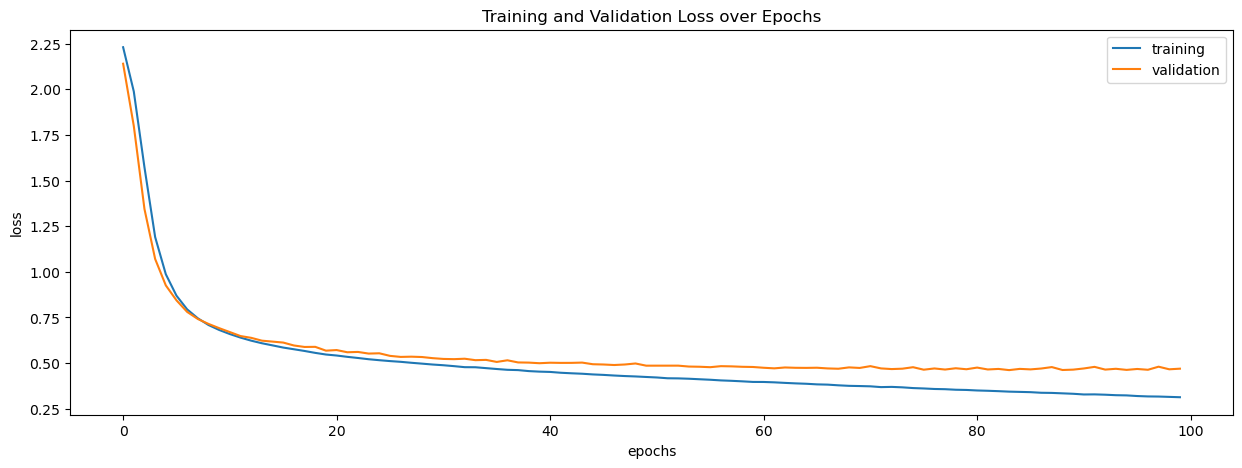

In [33]:
# Plot using matplotlib, make sure it is well labelled (Add title, axis labels, legend).

plt.figure(0, figsize=(15,5))
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
#plt.xticks(ticks=range(len(val_loss)))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

**(c) Plot training and validation accuracy.**

You should have two plots here on the same figure:

- Training accuracy 
- Validation accuracy 

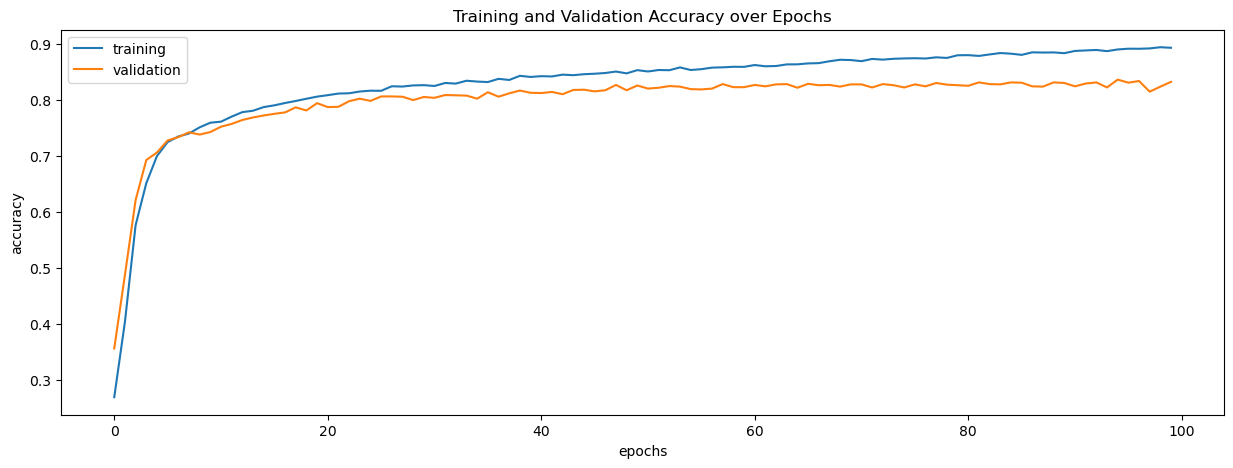

In [34]:
# Plot using matplotlib, make sure it is well labelled (Add title, axis labels, legend).
# Plot using matplotlib
plt.figure(1, figsize=(15, 5))
plt.plot(train_acc, label="training")
plt.plot(val_acc, label="validation")
#plt.xticks(ticks=range(len(val_acc)))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy over Epochs")
plt.legend()
plt.show()

**(d) Visualize predictions.**

Visualize 5 predictions of test set along with groundtruths and input images for the MLP.

Predicting: 0it [00:00, ?it/s]

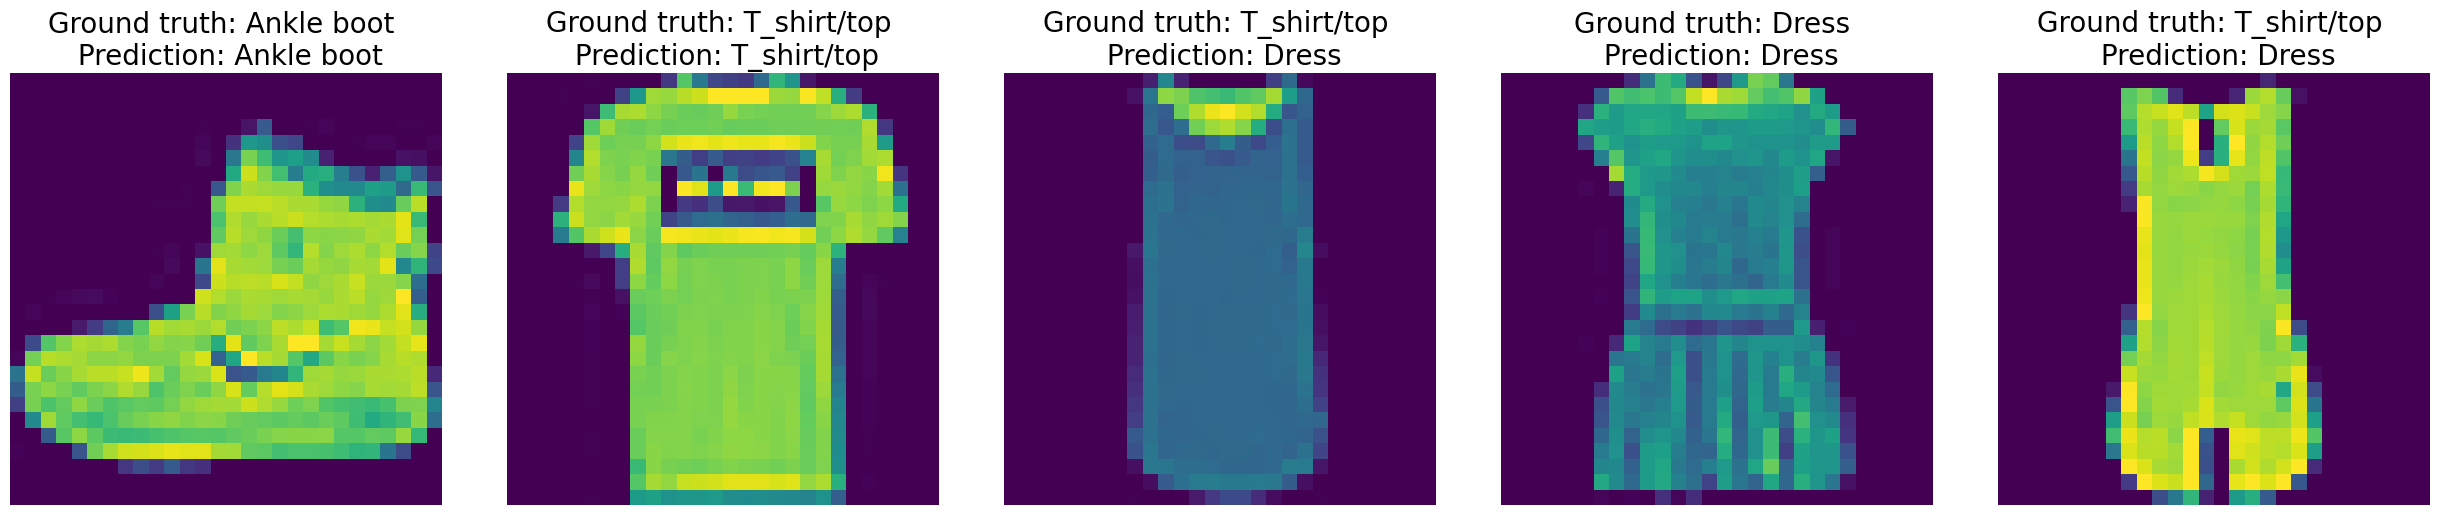

In [37]:
# Generate predictions using predict function
outputs = task3_trainer.predict(task3_model, testloader)
predictions_task3, labels_task3, inputs_task3 = outputs[0]

# visualize predictions along with ground truths and input images using matplotlib
# You will need to write your own code to visualize the prediction
# You may need to move your variables to cpu
label_list = [
    "T_shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Make your subplots
# It is recommended to have the ground truth and prediction within the title for each image
# You only need to select 5 images
num_images = 5
image_list = inputs_task3[:num_images]

num_cols = 5
num_rows = 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*5, 5*num_rows))
for i in range(num_images):
    ax = axes[i]
    ax.axis("off")
    ax.imshow(image_list[i, 0])
    title_text = f"Ground truth: {label_list[labels_task3[i]]} \n Prediction: {label_list[predictions_task3[i]]}"
    ax.set_title(title_text, fontsize = 20)
plt.tight_layout()
plt.show()

**(e) Compute and Visualize Confusion Matrix for Model Predictions**

To compute the Confusion Matrix in this task, you can leverage the built-in function `ConfusionMatrix` from the `torchmetrics` library. Afterward, you can effectively visualize the matrix using the `matplotlib` library.

In [40]:
# Define the number of classes
num_classes = 10

# Initialize the ConfusionMatrix object
confusion_matrix = np.zeros((num_classes, num_classes))

# Set the model to evaluation mode
# Disable gradient calculation during evaluation
# Iterate through the testloader, get predicted labels by forward passing and update the confusion matrix
task3_model.eval()
with torch.no_grad():
    for batch in testloader:
        x, y = batch
        logits = task3_model(x)
        preds = logits.argmax(1)
        #all_predictions.append(preds)
        #all_labels.append(y)
        
        num_items = len(preds)
        for i in range(num_items):
            confusion_matrix[preds[i], y[i]] += 1

# Compute the confusion matrix


# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
[[5.201e+03 2.900e+01 1.140e+02 3.320e+02 2.800e+01 1.000e+01 1.171e+03
  0.000e+00 4.900e+01 2.000e+00]
 [2.600e+01 5.764e+03 9.000e+00 7.300e+01 8.000e+00 0.000e+00 1.100e+01
  0.000e+00 2.000e+00 1.000e+00]
 [1.110e+02 5.100e+01 4.851e+03 6.800e+01 6.230e+02 0.000e+00 7.730e+02
  0.000e+00 5.300e+01 2.000e+00]
 [2.410e+02 1.260e+02 6.800e+01 5.103e+03 1.550e+02 2.000e+00 2.000e+02
  0.000e+00 3.700e+01 1.000e+00]
 [1.300e+01 1.300e+01 5.980e+02 2.780e+02 4.785e+03 0.000e+00 5.450e+02
  0.000e+00 2.600e+01 0.000e+00]
 [1.100e+01 0.000e+00 8.000e+00 1.000e+00 5.000e+00 5.612e+03 6.000e+00
  3.090e+02 6.500e+01 1.750e+02]
 [3.380e+02 1.500e+01 3.050e+02 1.200e+02 3.740e+02 4.000e+00 3.216e+03
  0.000e+00 8.300e+01 1.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 1.000e+00 0.000e+00 2.300e+02 1.000e+00
  5.436e+03 3.000e+01 2.330e+02]
 [5.800e+01 1.000e+00 4.700e+01 2.400e+01 2.200e+01 3.500e+01 7.500e+01
  1.400e+01 5.651e+03 5.000e+00]
 [1.000e+00 0.000e+00 0.000e+00 0.000

When visualizing the Confusion Matrix, ensure that the True labels are represented on the X-axis and the Predicted labels are represented on the Y-axis.

Include 10 class labels as tick marks.

Class labels: _T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot_

[Text(0, 0, 'T_shirt/top'),
 Text(0, 1, 'Trouser'),
 Text(0, 2, 'Pullover'),
 Text(0, 3, 'Dress'),
 Text(0, 4, 'Coat'),
 Text(0, 5, 'Sandal'),
 Text(0, 6, 'Shirt'),
 Text(0, 7, 'Sneaker'),
 Text(0, 8, 'Bag'),
 Text(0, 9, 'Ankle boot')]

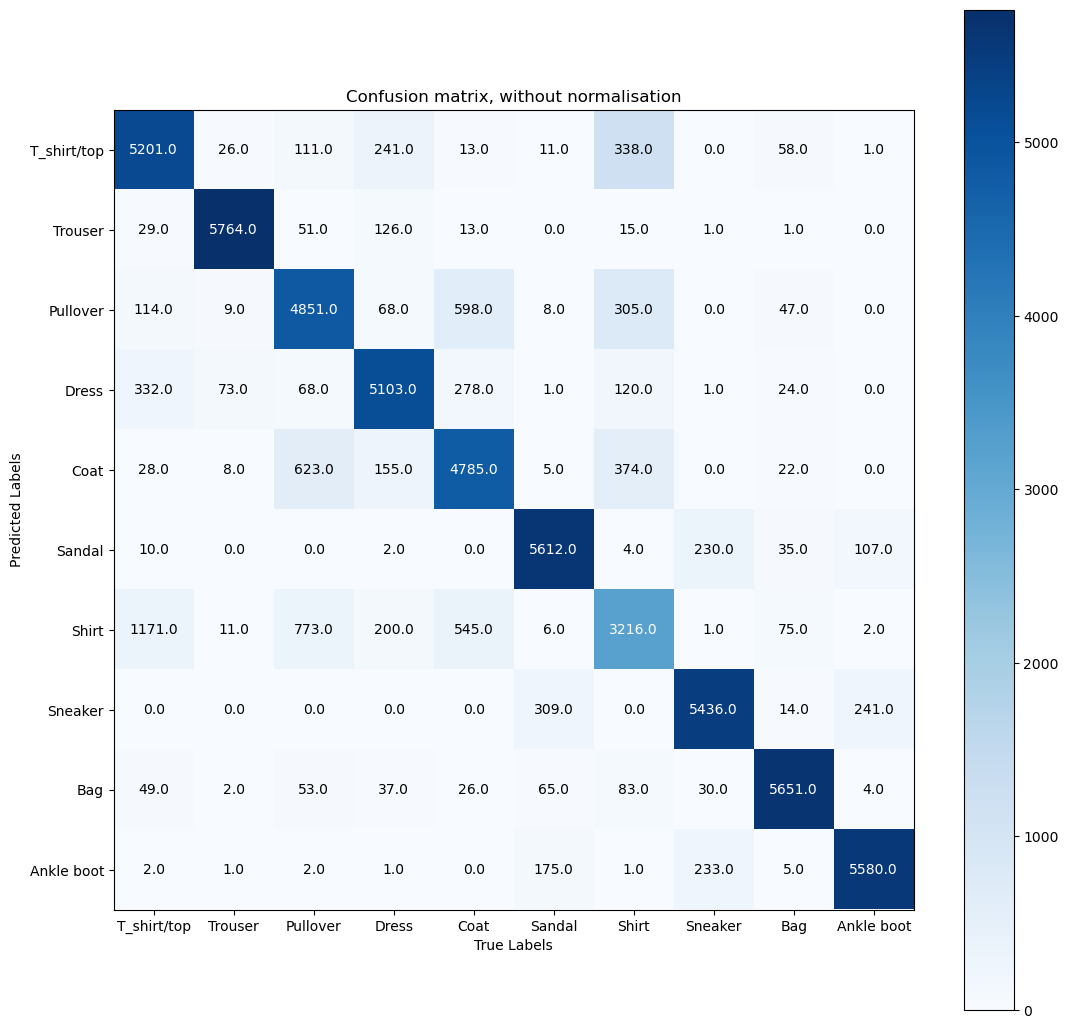

In [48]:
# Get the confusion matrix in numpy form
#confusion_matrix = ???

# Plot the confusion matrix
fig = plt.figure(figsize=(10,10))
axes = fig.add_axes([0,0,1,1])
plt.imshow(confusion_matrix, cmap="Blues")
plt.colorbar()
# add text
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        value = confusion_matrix[i, j]
        if value > 3000:
            color = "w"
        else:
            color = "k"
        plt.text(i,j,value,ha='center',va='center', color=color)

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.title("Confusion matrix, without normalisation")
# label the ticks
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(label_list)
axes.set_yticks([0,1,2,3,4,5,6,7,8,9])
axes.set_yticklabels(label_list)

<div class="alert alert-block alert-success">

### Discussion

1. What can you say about the losses/accuracy curves for task 3 compared to tasks 1 & 2? Is it a lot less noisy? Why would this be the case?
    
2. Analyse and describe the results stemming from the confusion matrix. Which class had the highest accuracy? Which class had the lowest accuracy? Can you explain why?

### Answer: 

1. Task 3's validation performance plateaus while the training performance steadily increases, towards the tail end of the training. This means that while the model is adapting to the training set, it is failing to improve further for the validation set. The graphs are also less noisy than the graphs for task 1. This is because the increase in the batch sizes. The batches can be thought of as sampling from a distribution. The larger the sample size, the less likely the sample will collectively deviate from the population. This reduces the chance of a misstep in gradient descent, which results in less noise in the loss and accuracy graphs. 

2. The confusion matrix is mostly dark along the diagonal, which is a good sign - the model is adequately distinguishing between the classes. The model performs best for trousers, sandals, bags, and ankle boots. This is because those items have enough distinguishing features to stand out from the other classes. The model performs poorly for shirts, sometimes confusing it with T-shirts. This is due to the similarity between shirts and T_shirts. 

<div class="alert alert-block alert-danger">

# <p style="text-align: center;">The End</p>